In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from score_analysis import showbias
from score_analysis.showbias_plotting import (
    plot_multiple_thresholds,
    plot_single_threshold,
)

rng = np.random.default_rng()

## Create some toy data

In its simplest case, the showbias function assumes that you have a pandas dataframe with three columns:
- a `group` column that indicates group membership for every row, e.g. female and male values in a column called gender
- a `scores` column that contains the predicted scores (e.g. by a model) for
- a `labels` column that contains the ground truth using integers

Below we create a synthetic dataset that contains dogfido<b><sup>TM</sup></b> IDV data for different dog breeds

In [2]:
dog_breeds = ["German Shepherd", "Golden Retriever", "Bulldog", "Beagle"]
genders = ["male", "female"]
n = 1_000

df = pd.DataFrame(
    {
        "breed": rng.choice(dog_breeds, size=n),
        "gender": rng.choice(genders, size=n),
        "labels": rng.choice([0, 1], size=n),
        "scores": rng.uniform(0.0, 1.0, size=n),
    }
)

In [3]:
df.head()

,breed,gender,labels,scores
0,Golden Retriever,male,0,0.891101
1,Golden Retriever,female,0,0.851230
2,Golden Retriever,male,0,0.613578
3,German Shepherd,male,0,0.879887
4,Beagle,female,0,0.911576


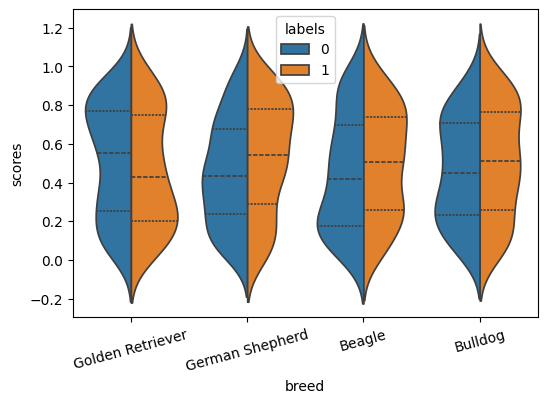

In [4]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="breed", y="scores", hue="labels", split=True, inner="quart")
plt.xticks(rotation=15)
plt.show()

## Showbias vanilla version

In [5]:
bias_frame = showbias(
    data=df,
    group_columns=["breed", "gender"],
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.5],
)

In [6]:
bias_frame.values

0.5
breed            gender          
Beagle           female  0.466667
                 male    0.500000
Bulldog          female  0.483871
                 male    0.480769
German Shepherd  female  0.410714
                 male    0.463768
Golden Retriever female  0.507463
                 male    0.619048

## Passing several thresholds at once

In [7]:
bias_frame = showbias(
    data=df,
    group_columns=["breed", "gender"],
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.3, 0.5, 0.7],
)
bias_frame.values

0.3       0.5       0.7
breed            gender                              
Beagle           female  0.283333  0.466667  0.733333
                 male    0.350000  0.500000  0.666667
Bulldog          female  0.225806  0.483871  0.645161
                 male    0.346154  0.480769  0.711538
German Shepherd  female  0.214286  0.410714  0.535714
                 male    0.304348  0.463768  0.739130
Golden Retriever female  0.313433  0.507463  0.656716
                 male    0.428571  0.619048  0.777778

## Normalizing metric

You can obtain metrics that are normalized to the metric measured across the entire dataset by passing the `normalize` argument, like so:

In [8]:
bias_frame = showbias(
    data=df,
    group_columns=["breed", "gender"],
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.5],
    normalize="by_overall",
)
bias_frame.values

0.5
breed            gender          
Beagle           female  0.946888
                 male    1.014523
Bulldog          female  0.981796
                 male    0.975503
German Shepherd  female  0.833358
                 male    0.941007
Golden Retriever female  1.029665
                 male    1.256076

## What is a BiasFrame?

In [9]:
type(bias_frame)

score_analysis.showbias.BiasFrame

In [10]:
print(bias_frame)

BiasFrame(values=                              0.5
breed            gender          
Beagle           female  0.946888
                 male    1.014523
Bulldog          female  0.981796
                 male    0.975503
German Shepherd  female  0.833358
                 male    0.941007
Golden Retriever female  1.029665
                 male    1.256076, alpha=None, lower=None, upper=None)


In [11]:
type(bias_frame.values)

pandas.core.frame.DataFrame

## Confidence intervals

You can obtain confidence intervals by setting the `bootstrap_ci` to `True`:

In [12]:
bias_frame = showbias(
    data=df,
    group_columns=["breed", "gender"],
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.5],
    bootstrap_ci=True,
)

In [13]:
bias_frame.values

0.5
breed            gender          
Beagle           female  0.466667
                 male    0.500000
Bulldog          female  0.483871
                 male    0.480769
German Shepherd  female  0.410714
                 male    0.463768
Golden Retriever female  0.507463
                 male    0.619048

In [14]:
bias_frame.lower

0.5
breed            gender          
Beagle           female  0.333333
                 male    0.386250
Bulldog          female  0.351583
                 male    0.349770
German Shepherd  female  0.297236
                 male    0.354839
Golden Retriever female  0.388725
                 male    0.491809

In [15]:
bias_frame.upper

0.5
breed            gender          
Beagle           female  0.589093
                 male    0.634856
Bulldog          female  0.600000
                 male    0.631453
German Shepherd  female  0.548773
                 male    0.592101
Golden Retriever female  0.629909
                 male    0.737758

In [16]:
print(bias_frame.to_markdown())

|                                | 0.5             |
|:-------------------------------|:----------------|
| ('Beagle', 'female')           | 0.467           |
|                                | (0.333 - 0.589) |
| ('Beagle', 'male')             | 0.5             |
|                                | (0.386 - 0.635) |
| ('Bulldog', 'female')          | 0.484           |
|                                | (0.352 - 0.6)   |
| ('Bulldog', 'male')            | 0.481           |
|                                | (0.35 - 0.631)  |
| ('German Shepherd', 'female')  | 0.411           |
|                                | (0.297 - 0.549) |
| ('German Shepherd', 'male')    | 0.464           |
|                                | (0.355 - 0.592) |
| ('Golden Retriever', 'female') | 0.507           |
|                                | (0.389 - 0.63)  |
| ('Golden Retriever', 'male')   | 0.619           |
|                                | (0.492 - 0.738) |


## BiasFrame methods

### to_markdown()

In [17]:
bias_frame_md = bias_frame.to_markdown(
    reset_display_index=True, number_decimal_points=5
)
print(bias_frame_md)

| breed            | gender   | 0.5                 |
|:-----------------|:---------|:--------------------|
| Beagle           | female   | 0.46667             |
|                  |          | (0.33333 - 0.58909) |
| Beagle           | male     | 0.5                 |
|                  |          | (0.38625 - 0.63486) |
| Bulldog          | female   | 0.48387             |
|                  |          | (0.35158 - 0.6)     |
| Bulldog          | male     | 0.48077             |
|                  |          | (0.34977 - 0.63145) |
| German Shepherd  | female   | 0.41071             |
|                  |          | (0.29724 - 0.54877) |
| German Shepherd  | male     | 0.46377             |
|                  |          | (0.35484 - 0.5921)  |
| Golden Retriever | female   | 0.50746             |
|                  |          | (0.38872 - 0.62991) |
| Golden Retriever | male     | 0.61905             |
|                  |          | (0.49181 - 0.73776) |


## Plotting functionality

### plot_single_threshold

In [18]:
dog_breeds = ["German Shepherd", "Golden Retriever", "Bulldog", "Beagle"]
n = 1_000

df = pd.DataFrame(
    {
        "breed": rng.choice(dog_breeds, size=n),
        "labels": rng.choice([0, 1], size=n),
        "scores": rng.uniform(0.0, 1.0, size=n),
    }
)

bias_frame = showbias(
    data=df,
    group_columns="breed",
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.5],
    bootstrap_ci=True,
)

/var/folders/3x/scxt8h1148g87lkz1v9w_dwh0000gn/T/ipykernel_33237/1552096427.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


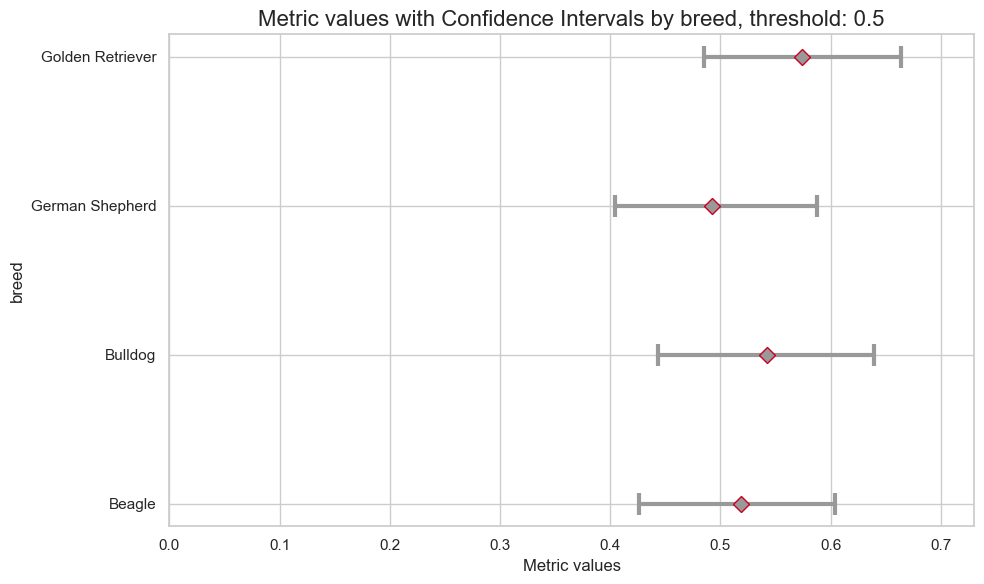

In [19]:
plot = plot_single_threshold(bias_frame, threshold=0.5)
plot.show()

### plot_multiple_thresholds

In [20]:
bias_frame = showbias(
    data=df,
    group_columns="breed",
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=np.linspace(0.0, 1.0, 1000),
)

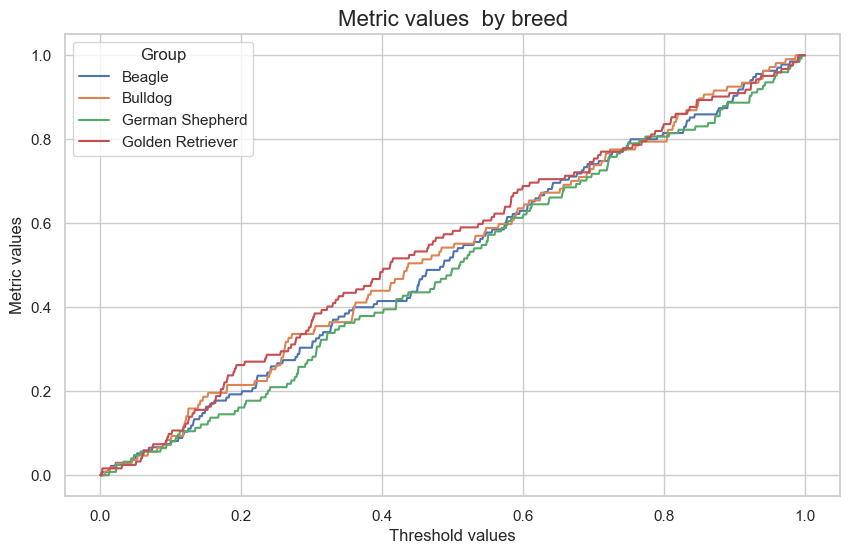

In [21]:
plot = plot_multiple_thresholds(bias_frame)
plt.show()

## Available metrics

`showbias` supports all metrics that are supported by `score-analysis`.
Currently, you can pass any of the strings below to the metric argument in showbias:

Basic parameters:
- "tp" (true positive)
- "tn" (true negative)
- "fp" (false positive)
- "fn" (false negative)
- "p" (condition positive)
- "n" (condition negative)
- "top" (test outcome positive)
- "ton" (test outcome negative)
- "pop" (population counts)

Class metrics
- "tpr" (true positive rate)
- "tnr" (true negative rate)
- "fpr" (false positive rate)
- "fnr" (false negative rate)
- "topr" (test outcome positive rate)
- "tonr" (test outcome negative rate)
- "ppv" (positive predictive value)
- "npv" (negative predictive value)
- "fdr" (false discovery rate)
- "for_" (false omission rate)
- "class_accuracy" (class accuracy)
- "class_error_rate" (class_error_rate)

Overall metrics
- "accuracy" (Accuracy)
- "error_rate" (Error rate)